# Save and load data
Utilize a prior and a simulator to create said dataset. Save a proportion as a training set, and part as a validation set. Then, run SBI using this static training set. An alternate way to run SBI using a simulator to generate data on the fly is demonstrated in the `train_SBI.ipynb` tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# remove top and right axis from plots
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False

In [2]:
import sbi
from sbi.inference import SNPE
from sbi.inference.base import infer
from sbi.analysis import pairplot
import torch

In [3]:
from src.scripts.io import DataLoader, ModelLoader

In [4]:
def simulator(thetas):#, percent_errors):
    # convert to numpy array (if tensor):
    thetas = np.atleast_2d(thetas)
    # Check if the input has the correct shape
    if thetas.shape[1] != 2:
        raise ValueError("Input tensor must have shape (n, 2) where n is the number of parameter sets.")

    # Unpack the parameters
    if thetas.shape[0] == 1:
        # If there's only one set of parameters, extract them directly
        m, b = thetas[0, 0], thetas[0, 1]
    else:
        # If there are multiple sets of parameters, extract them for each row
        m, b = thetas[:, 0], thetas[:, 1]
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    # I'm thinking sigma could actually be a function of x
    # if we want to get fancy down the road
    # Generate random noise (epsilon) based on a normal distribution with mean 0 and standard deviation sigma
    sigma = 5
    ε = rs.normal(loc=0, scale=sigma, size=(len(x), thetas.shape[0]))
    
    # Initialize an empty array to store the results for each set of parameters
    y = np.zeros((len(x), thetas.shape[0]))
    for i in range(thetas.shape[0]):
        m, b = thetas[i, 0], thetas[i, 1]
        y[:, i] = m * x + b + ε[:, i]
    return torch.Tensor(y.T)

In [5]:
num_dim = 2

low_bounds = torch.tensor([0, -10])
high_bounds = torch.tensor([10, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)

To create the training set, sample from this prior and run it through the simulator.

In [6]:
params = prior.sample((10000,))
xs = simulator(params)
print(r'$\theta$s', params, 'xs', xs)


$\theta$s tensor([[ 2.8840, -7.0975],
        [ 6.8337, -5.9733],
        [ 2.4926, -5.7297],
        ...,
        [ 7.2979, -0.9311],
        [ 6.3926, -0.3290],
        [ 6.3816,  3.8464]]) xs tensor([[-11.4556,   9.8369,   4.9505,  ..., 277.5564, 291.7433, 285.3736],
        [-12.3848,   7.0872,  19.9406,  ..., 663.7286, 663.2328, 674.7347],
        [  0.8212,   1.4636,  -7.0082,  ..., 242.6000, 236.7188, 244.5201],
        ...,
        [ -3.1995,   6.4203,  21.6573,  ..., 712.5668, 715.9341, 730.9291],
        [ -3.1645,   6.0377,  15.8926,  ..., 622.5889, 629.9952, 634.9966],
        [ 12.4576,  13.1750,  17.9107,  ..., 628.2657, 635.1102, 644.2883]])


In [8]:
# Save both params and xs to a .pkl file
data_to_save = {'thetas': params, 'xs': xs}

dataloader = DataLoader()
dataloader.save_data_pkl('data_train',
                         data_to_save,
                         path = '../saveddata/')

Redo this with a validation set that is the same size.

In [9]:
params_valid = prior.sample((10000,))
xs_valid = simulator(params_valid)
print(r'$\theta$s', params_valid, 'xs', xs_valid)

$\theta$s tensor([[ 8.3111, -3.2867],
        [ 1.7166, -3.1525],
        [ 7.9723, -0.7460],
        ...,
        [ 2.2330,  0.8710],
        [ 1.7741,  2.2013],
        [ 8.7931, -1.1207]]) xs tensor([[-6.5503e-01, -1.4921e+00,  4.9110e+00,  ...,  8.1405e+02,
          8.2206e+02,  8.2703e+02],
        [ 2.4441e+00, -6.9449e+00,  6.2681e+00,  ...,  1.7136e+02,
          1.7441e+02,  1.7407e+02],
        [-3.1070e+00, -8.2457e-01,  1.3257e+01,  ...,  7.7915e+02,
          7.8097e+02,  7.9491e+02],
        ...,
        [-8.7920e-01, -3.1205e-01,  1.3718e+00,  ...,  2.1731e+02,
          2.2758e+02,  2.3235e+02],
        [ 5.3797e+00,  3.6299e+00,  1.3066e+01,  ...,  1.7667e+02,
          1.8707e+02,  1.7228e+02],
        [-3.1299e+00,  6.9778e+00,  1.9069e+01,  ...,  8.6182e+02,
          8.7560e+02,  8.7489e+02]])


In [10]:
# Save both params and xs to a .pkl file
data_to_save_valid = {'thetas': params_valid, 'xs': xs_valid}

dataloader.save_data_pkl('data_validation',
                         data_to_save_valid,
                         path = '../saveddata/')

## Now load up this data and run SBI using it

In [11]:
train_pkl = dataloader.load_data_pkl(
                         'data_train',
                        '../saveddata/',)

../saveddata/


In [12]:
print(train_pkl)

{'thetas': tensor([[ 2.8840, -7.0975],
        [ 6.8337, -5.9733],
        [ 2.4926, -5.7297],
        ...,
        [ 7.2979, -0.9311],
        [ 6.3926, -0.3290],
        [ 6.3816,  3.8464]]), 'xs': tensor([[-11.4556,   9.8369,   4.9505,  ..., 277.5564, 291.7433, 285.3736],
        [-12.3848,   7.0872,  19.9406,  ..., 663.7286, 663.2328, 674.7347],
        [  0.8212,   1.4636,  -7.0082,  ..., 242.6000, 236.7188, 244.5201],
        ...,
        [ -3.1995,   6.4203,  21.6573,  ..., 712.5668, 715.9341, 730.9291],
        [ -3.1645,   6.0377,  15.8926,  ..., 622.5889, 629.9952, 634.9966],
        [ 12.4576,  13.1750,  17.9107,  ..., 628.2657, 635.1102, 644.2883]])}


In [13]:
# instantiate the neural density estimator
neural_posterior = sbi.utils.posterior_nn(model='maf')

'''
model,
                                  embedding_net=embedding_net,
                                  hidden_features=hidden_features,
                                  num_transforms=num_transforms)
'''

#from me:
#infer(simulator, prior, "SNPE", num_simulations=10000)

low_bounds = torch.tensor([0, -10])
high_bounds = torch.tensor([10, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior, device="cpu")


density_estimator = inference.append_simulations(train_pkl['thetas'],train_pkl['xs']).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 58 epochs.

In [14]:
modelloader = ModelLoader()
path = "../savedmodels/sbi/"
model_name = "sbi_linear_from_data"
modelloader.save_model_pkl(path, model_name, posterior)

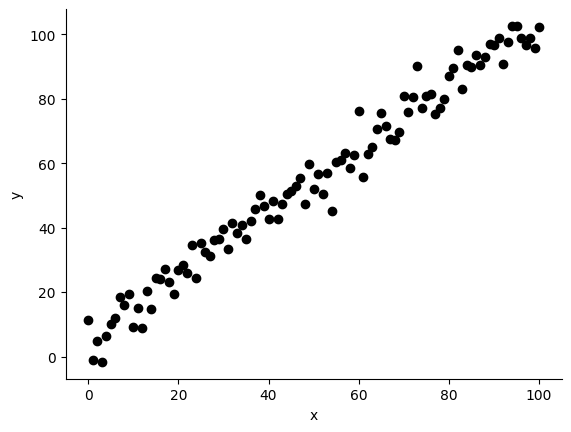

In [15]:
# generate a true dataset
theta_true = [1, 5]
y_true = simulator(theta_true)

# and visualize it
plt.clf()
plt.scatter(np.linspace(0, 100, 101),
            np.array(y_true), color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

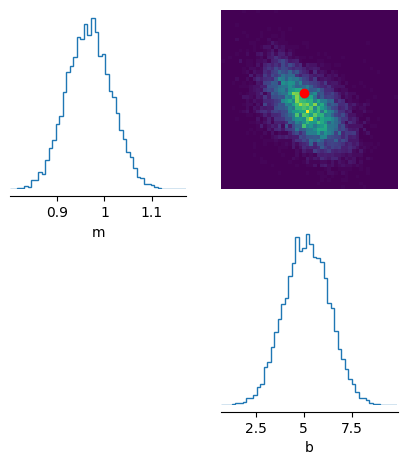

In [16]:
# sample from the posterior
posterior_samples_1 = posterior.sample((10000,), x = y_true)
# that last little part is conditioning on a data value
# plot posterior samples
fig, axes = sbi.analysis.pairplot(
    posterior_samples_1, 
    labels = ['m', 'b'],
    #limits = [[0,10],[-10,10],[0,10]],
    truths = theta_true,
    figsize=(5, 5)
)
axes[0, 1].plot([theta_true[1]], [theta_true[0]], marker="o", color="red")